In [262]:
from data_parser import Butlr32_Data
import numpy as np
import cv2
import math
from scipy import ndimage, signal
from skimage.feature import blob_log
%matplotlib inline
import matplotlib.pyplot as plt
import copy

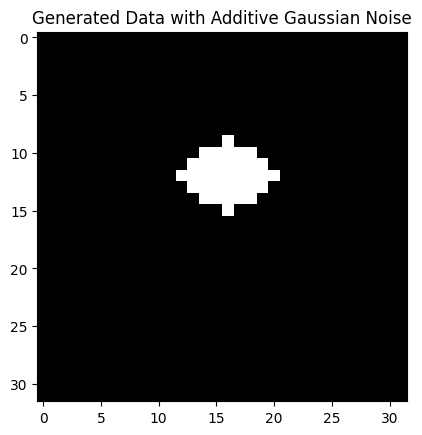

In [280]:
def DataGeneration(frames = 1000, size = 32, std_deviation = 0.2):
    oval_radius_x = 3
    oval_radius_z = 4

    def create_frame(y, d):
        frame = np.zeros((size, size))
        for x in range(size):
            for z in range(size):
                if (
                    (x - size // 2) ** 2 / oval_radius_x**2
                    + (z - size // 2) ** 2 / oval_radius_z**2
                ) <= 1:
                    frame[x, z] = 1
                else:
                    frame[x, z] = 0
        if y%20 < 10:
            d += 1
        else:
            d -= 1
        return np.ravel(np.roll(frame, d-5, axis=0)), d

    d = 0
    s = 0
    matrix_3d = []
    velocity = []

    for y in range(frames):
        frame,d = create_frame(y, d)
        matrix_3d.append(frame)
        velocity.append([0,d - s])
        s = d
    velocity.pop()
    matrix_3d = np.array(matrix_3d)
    noisy_matrix_3d = matrix_3d.copy()

    # Adding noise to each frame
    for i in range(frames):
        noise = np.random.normal(0, std_deviation, matrix_3d.shape[1])
        noise_frame = noisy_matrix_3d[i] + noise
        noisy_matrix_3d[i] = (noise_frame - np.min(noise_frame)) / (
            np.max(noise_frame) - np.min(noise_frame)
        )

    return np.reshape(noisy_matrix_3d, (len(noisy_matrix_3d), 32, 32)), np.array(velocity)

data, velocity = DataGeneration(100, 32, 0)
plt.title("Generated Data with Additive Gaussian Noise")
plt.imshow(data[0], cmap="gray")
plt.show()

In [249]:
def GaussBlur(frame):
    filtered_frame = ndimage.gaussian_filter(frame, sigma=0.8)
    return filtered_frame

def MedianGauss(frame):
    filtered_frame = ndimage.median_filter(frame, size=4)
    filtered_frame = ndimage.gaussian_filter(filtered_frame, sigma=0.1)
    return filtered_frame

def ThreshMG(frame):
    filtered_frame = ndimage.median_filter(frame, size=4)
    filtered_frame = ndimage.gaussian_filter(filtered_frame, sigma=0.1)
    thresh = filtered_frame > 0.65
    return thresh

def ThreshBlob(frame):
    new_frame = ndimage.gaussian_filter(frame, sigma=1)
    blobs = blob_log(new_frame, min_sigma=0.5, max_sigma=2, threshold=0.1, overlap=1)
    y, x, area = blobs[np.argmax(blobs[:, 2])]
    thresh = new_frame > (new_frame[int(y), int(x)] - 0.1)
    return thresh

In [250]:
def GaussKernel(n, x0, y0, sigma = 0.1):
    x, y = np.arange(n), np.arange(n)

    gx = np.exp(-((x - x0) ** 2) / (2 * sigma**2))
    gy = np.exp(-((y - y0) ** 2) / (2 * sigma**2))
    g = np.outer(gx, gy)
    g /= np.sum(g)
    
    return g

In [251]:
def LK_OF(img1, img2, w, tau=1e-2):
    # Compute I_x, I_y, and I_t
    k_x = np.array([[-.25, .25], [-.25, .25]])
    k_y = np.array([[-.25, -.25], [.25, .25]])
    k_t = np.array([[.25, .25], [.25, .25]])
    I_x = signal.convolve2d(img1, k_x, boundary="symm", mode="same")
    I_y = signal.convolve2d(img1, k_y, boundary="symm", mode="same")
    I_t = signal.convolve2d(
        img1, k_t, boundary="symm", mode="same"
    ) - signal.convolve2d(img2, k_t, boundary="symm", mode="same")
    u = np.zeros(img1.shape)
    v = np.zeros(img1.shape)
    for i in range(w//2, img1.shape[0] - w//2):
        for j in range(w//2, img1.shape[1] - w//2):
            I_xw = np.array(I_x[i-w//2:i+w//2+1,j-w//2:j+w//2+1]).flatten()
            I_yw = np.array(I_y[i-w//2:i+w//2+1,j-w//2:j+w//2+1]).flatten()
            a = np.matrix((I_xw, I_yw)).transpose()
            a_T = np.matrix.transpose(a)
            s_tensor = np.matmul(a_T, a)
            e, _ =np.linalg.eig(s_tensor)
            if tau < min(e):
                s_tensor_inv = np.linalg.pinv(s_tensor)
                b = np.matrix(-I_t[i-w//2:i+w//2+1,j-w//2:j+w//2+1]).reshape((w**2, 1))
                (u[i,j],v[i,j])= np.matmul(s_tensor_inv, np.matmul(a_T, b))
    return u, v

In [252]:
def MF_OF(feature, u, v, prev_x = -1, prev_y = -1):
    if prev_x < 0 or prev_y < 0:
        blobs = blob_log(feature, min_sigma=0.3, max_sigma=3, threshold=0.1, overlap=1)
        if blobs.size != 0:
            y0, x0, area = blobs[np.argmax(blobs[:, 2])]
            g_kernal = GaussKernel(32, x0, y0, area)
        else:
            x0 = prev_x
            y0 = prev_y
            g_kernal = GaussKernel(32, x0, y0)
    else:
        print("Previous existed at", prev_x, prev_y)
        x0 = prev_x
        y0 = prev_y
        g_kernal = GaussKernel(32, x0, y0)
    x1 = np.sum(np.multiply(u, g_kernal))
    y1 = np.sum(np.multiply(v, g_kernal))
    return x0, y0, x1, y1

In [319]:
def ApplyOF(data, index, window_size=3, tau=0.01, filter=lambda x: x):
    data_frame1 = filter(data[index])
    data_frame2 = filter(data[index+1])
    u, v = LK_OF(data_frame1, data_frame2, window_size, tau)
    fig = plt.figure("")
    plt.title("Real Data with Calculated Motion field")
    plt.imshow(data[index], cmap="gray")
    feature = np.zeros(u.shape)
    for i in range(u.shape[0]):
        for j in range(u.shape[1]):
            if u[i,j] != 0 or v[i,j] !=0:
                plt.arrow(
                    j,
                    i,
                    u[i, j],
                    v[i, j],
                    head_width=0.5,
                    head_length=0.5,
                    color="red",
                    alpha=0.3
                )
                feature[i,j] = 1
    x0, y0, x1, y1 = MF_OF(feature, u, v)
    plt.arrow(
        x0,
        y0,
        x1,
        y1,
        head_width=0.5,
        head_length=0.5,
        color="blue",
    )
    fig.canvas.draw()

    return data_frame1, data_frame2, u, v

C:\Users\Mark\AppData\Local\Temp\ipykernel_10816\3064175540.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (u[i,j],v[i,j])= np.matmul(s_tensor_inv, np.matmul(a_T, b))


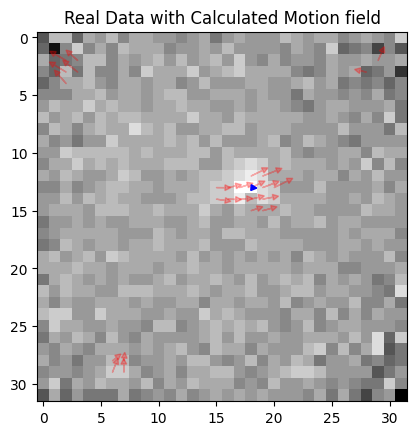

In [320]:
frame1, frame2, u, v = ApplyOF(data, index=30, window_size=5, tau=2, filter=GaussBlur)

In [340]:
def visualization(data, fps, op=None, window_size=3, tau=0.01, filter=lambda x: x):
    prev_x = prev_y = -1
    videoName = "output.mp4"
    fourcc = cv2.VideoWriter_fourcc(*"MP4V")
    videoOut = cv2.VideoWriter(videoName, fourcc, fps, (640, 480))
    for i in range(data.shape[0]):

        data_frame1 = filter(data[i])

        data_frame2 = filter(data[i+1])

        frame = np.zeros((32, 32, 3), dtype="uint8")

        frame[:, :, 0] = data_frame1 * 255

        frame[:, :, 1] = data_frame1 * 255

        frame[:, :, 2] = data_frame1 * 255

        if op != None and i != data.shape[0]-1:

            u, v = op(data_frame1, data_frame2, window_size, tau)

            fig = plt.figure("")
            ax = plt.gca()
            ax.set_xlim([-2, 34])
            ax.set_ylim([-2, 34])
            plt.imshow(data[i], cmap="gray")
            feature = np.zeros(u.shape)
            for i in range(u.shape[0]):
                for j in range(u.shape[1]):
                    if u[i,j] != 0 or v[i,j] !=0:
                        plt.arrow(
                            j,
                            i,
                            u[i, j],
                            v[i, j],
                            head_width=0.5,
                            head_length=0.5,
                            color="red",
                            alpha=0.3,
                        )
                        feature[i, j] = 1
            x0, y0, x1, y1 = MF_OF(feature, u, v, prev_x, prev_y)
            plt.arrow(
                x0,
                y0,
                x1,
                y1,
                head_width=0.5,
                head_length=0.5,
                color="blue",
            )
            fig.canvas.draw()

            img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep="")

            img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))

            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

            plt.close()

        else:
            img = frame

        cv2.namedWindow("Visualize Data", cv2.WINDOW_NORMAL)
        videoOut.write(img)

        cv2.imshow("Visualize Data", img)


        if cv2.waitKey(int(1000/fps)) & 0xFF == ord("q"):

            break


    cv2.destroyAllWindows()
    videoOut.release()

In [341]:
visualization(data, 20, op=LK_OF, window_size=5, tau=2, filter=GaussBlur)

C:\Users\Mark\AppData\Local\Temp\ipykernel_10816\3064175540.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (u[i,j],v[i,j])= np.matmul(s_tensor_inv, np.matmul(a_T, b))
C:\Users\Mark\AppData\Local\Temp\ipykernel_10816\494533360.py:45: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep="")
C:\Users\Mark\AppData\Local\Temp\ipykernel_10816\494533360.py:45: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep="")


(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)


In [304]:
upper_bond = 0.3
sigma_array = np.zeros(int(upper_bond*100))
correlation_array9 = np.zeros(int(upper_bond * 100))
for i in range(0, int(upper_bond * 100)):
    sigma = i * 0.01
    data, v_truth = DataGeneration(100, 32, sigma)
    v_calc = []
    for j in range(data.shape[0]):
        if j != data.shape[0]-1:
            data_frame1 = GaussBlur(data[j])
            data_frame2 = GaussBlur(data[j + 1])
            u, v = LK_OF(data_frame1, data_frame2, 3, 0.01)
            feature = np.zeros(u.shape)
            for k in range(u.shape[0]):
                for m in range(u.shape[1]):
                    if u[k,m] != 0 or v[k,m] !=0:
                        feature[k, m] = 1
            x0, y0, x1, y1 = MF_OF(feature, u, v)
            v_calc.append([x1, y1])
    v_calc = np.array(v_calc)
    diff = v_calc - v_truth
    sigma_array[i] = sigma
    correlation_array9[i] = np.linalg.norm(diff)

C:\Users\Mark\AppData\Local\Temp\ipykernel_10816\3064175540.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (u[i,j],v[i,j])= np.matmul(s_tensor_inv, np.matmul(a_T, b))


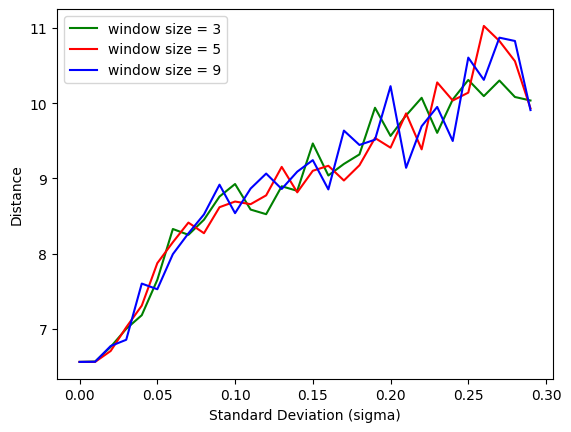

<Figure size 640x480 with 0 Axes>

In [305]:
plt.xlabel("Standard Deviation (sigma)")
plt.ylabel("Distance")
plt.plot(sigma_array, correlation_array3, color="g", label="window size = 3")
plt.plot(sigma_array, correlation_array5, color="r", label="window size = 5")
plt.plot(sigma_array, correlation_array9, color="b", label="window size = 9")
plt.legend()
plt.show()
plt.savefig("output.png")

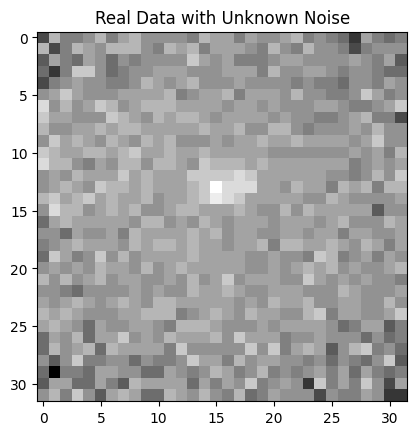

In [306]:
path = "data\\standing_9_32x32_sensor.txt"
frames = 2000
fps = 5
data_obj = Butlr32_Data(path)
length = data_obj.get_length()
data = []

for i in range(frames):
    data.append(data_obj.pop_frame())

data = np.array(data, dtype="uint8")
plt.title("Real Data with Unknown Noise")
plt.imshow(data[0], cmap="gray")
plt.show()

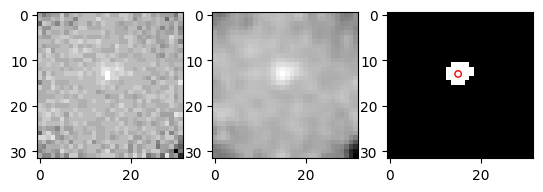

In [76]:
count = 1
frame = copy.deepcopy(data[count])

frame = (frame - np.min(frame)) / (np.max(frame) - np.min(frame))


fig = plt.figure()
plt.gray() 
ax1 = fig.add_subplot(131) 
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.imshow(frame)
new_frame = ndimage.gaussian_filter(frame, sigma=1)
ax2.imshow(new_frame)
blobs = blob_log(new_frame, min_sigma=0.5, max_sigma=2, threshold=0.1, overlap=1)
y, x, area = blobs[np.argmax(blobs[:, 2])]
thresh = new_frame > (new_frame[int(y), int(x)] - 0.1)
ax3.imshow(thresh)
ax3.add_patch(plt.Circle((x, y), area * np.sqrt(2), color="r", fill=False))
plt.show()

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 1. 2. 0. 2. 0. 0. 2. 0. 2. 1. 1. 1. 1. 0.
  2. 0. 2. 2. 0. 0. 0. 0.]
 [0. 0. 2. 0. 2. 0. 0. 1. 1. 2. 2. 0. 2. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0.
  2. 0. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 2. 0. 1. 0. 1. 1. 0. 0. 2. 2. 2. 0. 1. 2. 2. 1. 0. 0.
  2. 2. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 2. 0. 2. 0. 2. 2. 0. 0. 0.
  2. 2. 2. 2. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 2. 2. 0. 0. 2. 0. 0. 0. 1. 0. 0. 0. 0.
  2. 2. 2. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 1. 0. 0. 0.
  2. 2. 2. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 1. 0. 0. 2.
  2. 0. 2. 0. 0. 0. 0. 0.]
 [0. 0. 2. 1. 0. 0. 0. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 1. 1. 1. 1.
  2. 0. 0. 0. 0. 

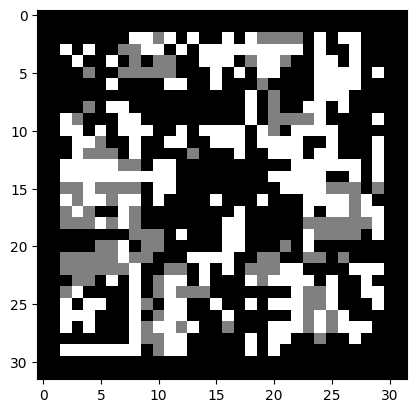

In [209]:
def test_OF(img1, img2, w, tau=1e-2):
    # Compute I_x, I_y, and I_t
    k_x = np.array([[-0.25, 0.25], [-0.25, 0.25]])
    k_y = np.array([[-0.25, -0.25], [0.25, 0.25]])
    k_t = np.array([[0.25, 0.25], [0.25, 0.25]])
    I_x = signal.convolve2d(img1, k_x, boundary="symm", mode="same")
    I_y = signal.convolve2d(img1, k_y, boundary="symm", mode="same")
    I_t = signal.convolve2d(
        img1, k_t, boundary="symm", mode="same"
    ) - signal.convolve2d(img2, k_t, boundary="symm", mode="same")
    e_map = np.zeros(img1.shape)
    for i in range(w // 2, img1.shape[0] - w // 2):
        for j in range(w // 2, img1.shape[1] - w // 2):
            I_xw = np.array(
                I_x[i - w // 2 : i + w // 2 + 1, j - w // 2 : j + w // 2 + 1]
            ).flatten()
            I_yw = np.array(
                I_y[i - w // 2 : i + w // 2 + 1, j - w // 2 : j + w // 2 + 1]
            ).flatten()
            I_tw = np.array(
                I_t[i - w // 2 : i + w // 2 + 1, j - w // 2 : j + w // 2 + 1]
            ).flatten()
            a = np.matrix((I_xw, I_yw, I_tw)).transpose()
            a_T = np.matrix.transpose(a)
            s_tensor = np.matmul(a_T, a)
            e, _ = np.linalg.eig(s_tensor)
            e_map[i,j] = np.argmax(e)
    print(e_map)
    plt.imshow(e_map)
    plt.show
i = 0
test_OF(data[i],data[i+1], 5)